<a href="https://colab.research.google.com/github/sneha4948/Federated-Learning-for-Supply-Chain-Sensor-Data-Processing/blob/main/VAR%2C_KNN_Imputation_with_Simulated_data_flower_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing FLOWER, other requirements

In [ ]:
!pip install -q "flwr[simulation]" flwr-datasets

In [ ]:
# you might see a warning after running the command below, this can be ignored
# if you are running this outside Colab, you probably need to adjust the command below
# !pip install torch==1.13.1+cpu torchvision==0.14.1+cpu --extra-index-url https://download.pytorch.org/whl/cpu

In [ ]:
!pip install matplotlib

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
# Flower Simulation code
import flwr as fl
from flwr.common import Context

# Missing Value Imputation

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


In [ ]:
# Load the dataset
data = pd.read_excel('Data.xlsx')

# Display the first few rows to understand the structure
print(data.head())


   Temperature1  Humidity1  co2ppm1  Temperature2  Humidity2  co2ppm2  \
0         22.00      69.17   1171.0         23.50      63.80   2691.0   
1         21.99      69.23   1167.0         23.50      63.75   2688.0   
2         21.95      69.26   1164.0         23.50      63.81   2684.0   
3         21.93      69.43   1161.0         23.46      63.81   2681.0   
4         21.92      69.42   1157.0         23.44      63.90   2680.0   

   Temperature3  Humidity3  co2ppm3  
0         22.50      60.49      903  
1         22.47      60.28      912  
2         22.44      60.14      930  
3         22.45      60.44      996  
4         22.45      60.46     1139  


In [ ]:
# Select the first 1000 rows
data = data.iloc[:1000]

# Select the last 3 columns
sensor3_data = data.iloc[:, -3:]

# Rename columns for clarity if necessary
sensor3_data.columns = ['Temperature', 'Humidity', 'CO2']

# Display the selected data
print(sensor3_data.head())


   Temperature  Humidity   CO2
0        22.50     60.49   903
1        22.47     60.28   912
2        22.44     60.14   930
3        22.45     60.44   996
4        22.45     60.46  1139


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
sensor3_data.to_csv('sensor3_1000data.csv', index=False)
print("Dataset created and saved as sensor3_1000data.csv")

Dataset created and saved as sensor3_1000data.csv


In [ ]:
# Set a seed for reproducibility
np.random.seed(42)

# Introduce missingness at 10% of the data
missing_rate = 0.1
num_missing = int(np.floor(missing_rate * sensor3_data.size))

# Randomly choose indices to replace with NaN
missing_indices = (
    np.random.choice(
        sensor3_data.size,
        num_missing,
        replace=False
    )
)

# Flatten the data to make indexing easier
data_flat = sensor3_data.values.flatten()

# Introduce missing values
data_flat[missing_indices] = np.nan

# Reshape back to original shape
sensor3_data_missing = pd.DataFrame(
    data_flat.reshape(sensor3_data.shape),
    columns=sensor3_data.columns
)

# Display the data with missing values
print(sensor3_data_missing.head())


   Temperature  Humidity    CO2
0          NaN     60.49  903.0
1        22.47     60.28  912.0
2        22.44     60.14  930.0
3        22.45     60.44  996.0
4        22.45     60.46    NaN


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Find indices of rows without any missing values
complete_cases = sensor3_data_missing.dropna()

# Rows with missing values (to be imputed)
incomplete_cases = sensor3_data_missing[sensor3_data_missing.isnull().any(axis=1)]

# Display counts
print(f"Number of complete cases: {len(complete_cases)}")
print(f"Number of incomplete cases: {len(incomplete_cases)}")


Number of complete cases: 731
Number of incomplete cases: 269


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Fit the VAR model
model = VAR(complete_cases)
results = model.fit(maxlags=15, ic='aic')

# Display summary of the model
print(results.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Nov, 2024
Time:                     17:01:06
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -4.25377
Nobs:                     724.000    HQIC:                  -4.51041
Log likelihood:          -1324.77    FPE:                 0.00935665
AIC:                     -4.67172    Det(Omega_mle):      0.00855302
--------------------------------------------------------------------
Results for equation Temperature
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -0.273837         0.046683           -5.866           0.000
L1.Temperature         0.779108         0.037709           20.661           0.000
L1.Humidity            0.009827         0.003324  

In [ ]:
def impute_missing_values(data_with_missing, var_results):
    data_imputed = data_with_missing.copy()
    # Get the positions of missing values, sorted by row index
    missing_positions = np.array(np.where(data_with_missing.isnull())).T
    # Sort missing positions by row index to impute in order
    missing_positions = missing_positions[np.argsort(missing_positions[:, 0])]
    for row_idx, col_idx in missing_positions:
        start_idx = row_idx - var_results.k_ar
        if start_idx < 0:
            # Not enough lagged data; fill with column mean
            col_mean = data_imputed.iloc[:, col_idx].mean()
            data_imputed.iloc[row_idx, col_idx] = col_mean
            continue
        # Prepare lagged values
        lagged_values = data_imputed.iloc[start_idx:row_idx].values
        # Check for NaNs in lagged values
        if np.isnan(lagged_values).any():
            # Fill NaNs in lagged values with column means
            col_means = np.nanmean(data_imputed.values, axis=0)
            lagged_values = np.where(np.isnan(lagged_values), col_means, lagged_values)
        # Predict the next value
        forecast = var_results.forecast(y=lagged_values, steps=1)
        # Impute the missing value
        data_imputed.iloc[row_idx, col_idx] = forecast[0, col_idx]
    return data_imputed


In [ ]:
# Impute missing values
sensor3_data_imputed = impute_missing_values(sensor3_data_missing, results)

# Check for remaining missing values
num_remaining_missing = sensor3_data_imputed.isnull().sum().sum()
print(f"Number of missing values remaining after imputation: {num_remaining_missing}")


Number of missing values remaining after imputation: 0


In [ ]:
# Get the positions where data was missing
missing_positions = np.where(sensor3_data_missing.isnull())

# Original values at missing positions
original_values = sensor3_data.values[missing_positions]

# Imputed values at missing positions
imputed_values = sensor3_data_imputed.values[missing_positions]


In [ ]:
from scipy.stats import pearsonr

# Calculate MSE and MAE
mse = mean_squared_error(original_values, imputed_values)
mae = mean_absolute_error(original_values, imputed_values)

# Calculate Pearson Correlation Coefficient
corr_coef, _ = pearsonr(original_values, imputed_values)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Pearson Correlation Coefficient: {corr_coef:.4f}")


MSE: 899.8790
MAE: 3.8146
Pearson Correlation Coefficient: 0.9954


In [ ]:
# Examine the data ranges
print(sensor3_data.describe())


       Temperature     Humidity          CO2
count  1000.000000  1000.000000  1000.000000
mean     16.089270    66.042600   644.611000
std       2.668419     5.126842   202.352292
min      13.890000    54.820000   473.000000
25%      14.110000    61.657500   506.000000
50%      14.750000    68.135000   542.500000
75%      17.232500    70.312500   686.000000
max      22.500000    73.320000  1514.000000


In [ ]:
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")


RMSE: 29.9980


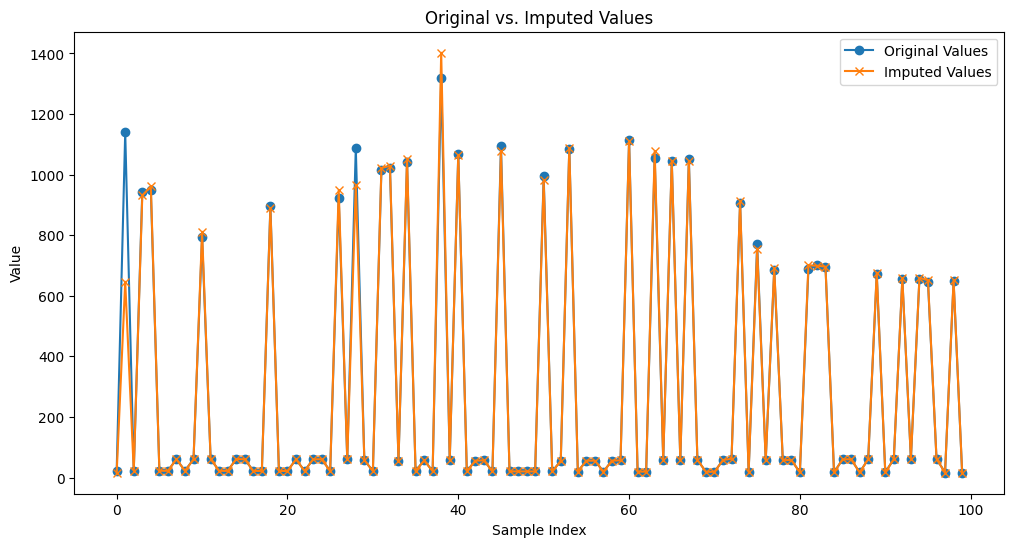

In [ ]:
# Plotting original vs. imputed values for the first 100 missing entries
plt.figure(figsize=(12, 6))
plt.plot(original_values[:100], label='Original Values', marker='o')
plt.plot(imputed_values[:100], label='Imputed Values', marker='x')
plt.title('Original vs. Imputed Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
# Reshape original and imputed values
original_values_array = original_values.reshape(-1, 3)
imputed_values_array = imputed_values.reshape(-1, 3)

# Separate errors for each variable
errors_temperature = imputed_values_array[:, 0] - original_values_array[:, 0]
errors_humidity = imputed_values_array[:, 1] - original_values_array[:, 1]
errors_co2 = imputed_values_array[:, 2] - original_values_array[:, 2]


In [ ]:
# Import necessary function
from sklearn.metrics import mean_squared_error

# Temperature
mse_temperature = mean_squared_error(original_values_array[:, 0], imputed_values_array[:, 0])
rmse_temperature = np.sqrt(mse_temperature)

# Humidity
mse_humidity = mean_squared_error(original_values_array[:, 1], imputed_values_array[:, 1])
rmse_humidity = np.sqrt(mse_humidity)

# CO2
mse_co2 = mean_squared_error(original_values_array[:, 2], imputed_values_array[:, 2])
rmse_co2 = np.sqrt(mse_co2)

print(f"Temperature - MSE: {mse_temperature:.4f}, RMSE: {rmse_temperature:.4f}")
print(f"Humidity - MSE: {mse_humidity:.4f}, RMSE: {rmse_humidity:.4f}")
print(f"CO2 - MSE: {mse_co2:.4f}, RMSE: {rmse_co2:.4f}")


Temperature - MSE: 34.3993, RMSE: 5.8651
Humidity - MSE: 2585.8814, RMSE: 50.8516
CO2 - MSE: 79.3562, RMSE: 8.9082


In [ ]:
# Total MSE
total_mse = mse_temperature + mse_humidity + mse_co2

# Proportion of MSE
prop_temperature = mse_temperature / total_mse
prop_humidity = mse_humidity / total_mse
prop_co2 = mse_co2 / total_mse

print(f"Proportion of MSE - Temperature: {prop_temperature:.2%}")
print(f"Proportion of MSE - Humidity: {prop_humidity:.2%}")
print(f"Proportion of MSE - CO2: {prop_co2:.2%}")


Proportion of MSE - Temperature: 1.27%
Proportion of MSE - Humidity: 95.79%
Proportion of MSE - CO2: 2.94%


# Using Standard Data and imputing only for Temperature

In [ ]:
# Load the dataset
data = pd.read_csv('sensor3_1000data.csv')  # Replace with your actual dataset filename

# Select the first 1000 rows
data = data.iloc[:1000]

# Select the last 3 columns (sensor3 data)
sensor3_data = data.iloc[:, -3:]
sensor3_data.columns = ['Temperature', 'Humidity', 'CO2']

# Display the data
print(sensor3_data.head())


   Temperature  Humidity   CO2
0        22.50     60.49   903
1        22.47     60.28   912
2        22.44     60.14   930
3        22.45     60.44   996
4        22.45     60.46  1139


In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
sensor3_data_scaled = pd.DataFrame(
    scaler.fit_transform(sensor3_data),
    columns=sensor3_data.columns
)

# Display the standardized data
print(sensor3_data_scaled.head())


   Temperature  Humidity       CO2
0     2.403647 -1.083587  1.277565
1     2.392399 -1.124568  1.322065
2     2.381150 -1.151889  1.411063
3     2.384900 -1.093344  1.737390
4     2.384900 -1.089441  2.444432


In [ ]:
# Set a seed for reproducibility
np.random.seed(42)

# Introduce missingness in 10% of the Temperature data
missing_rate = 0.1
num_missing = int(np.floor(missing_rate * len(sensor3_data_scaled)))

# Randomly choose indices to replace with NaN in Temperature column
missing_indices = np.random.choice(sensor3_data_scaled.index, num_missing, replace=False)

# Create a copy of the data to introduce missingness
sensor3_data_missing = sensor3_data_scaled.copy()

# Introduce missing values in Temperature
sensor3_data_missing.loc[missing_indices, 'Temperature'] = np.nan

# Display data with missing values
print(sensor3_data_missing.head(10))


   Temperature  Humidity       CO2
0     2.403647 -1.083587  1.277565
1     2.392399 -1.124568  1.322065
2     2.381150 -1.151889  1.411063
3     2.384900 -1.093344  1.737390
4     2.384900 -1.089441  2.444432
5     2.369902 -1.171404  2.301046
6     2.373651 -1.157744  1.717612
7     2.366153 -1.114811  1.485228
8     2.354904 -1.108956  1.470395
9     2.347406 -1.183113  1.485228


In [ ]:
# Identify missing positions in Temperature
missing_mask = sensor3_data_missing['Temperature'].isnull()

# Original Temperature values at missing positions (before introducing missingness)
original_temperature_values = sensor3_data_scaled.loc[missing_indices, 'Temperature'].values

# Data without missing values (complete cases)
complete_cases = sensor3_data_missing.dropna()

# Display counts
print(f"Total samples: {len(sensor3_data_missing)}")
print(f"Number of missing Temperature values: {missing_mask.sum()}")
print(f"Number of complete cases: {len(complete_cases)}")


Total samples: 1000
Number of missing Temperature values: 100
Number of complete cases: 900


In [ ]:
# Fit VAR model on complete cases
model_var = VAR(complete_cases)
results_var = model_var.fit(maxlags=15, ic='aic')

print(results_var.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Nov, 2024
Time:                     17:34:52
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -19.9428
Nobs:                     885.000    HQIC:                  -20.4037
Log likelihood:           5525.62    FPE:                1.03511e-09
AIC:                     -20.6890    Det(Omega_mle):     8.89137e-10
--------------------------------------------------------------------
Results for equation Temperature
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.004152         0.000628           -6.612           0.000
L1.Temperature          0.701494         0.034903           20.099           0.000
L1.Humidity             0.017813         0.005

In [ ]:
def var_impute(data_with_missing, var_results):
    data_imputed = data_with_missing.copy()
    # Get indices of missing Temperature values
    missing_indices = data_imputed[data_imputed['Temperature'].isnull()].index
    for idx in missing_indices:
        start_idx = idx - var_results.k_ar
        if start_idx < 0:
            # Not enough lagged data; fill with mean
            data_imputed.loc[idx, 'Temperature'] = data_imputed['Temperature'].mean()
            continue
        # Prepare lagged values
        lagged_values = data_imputed.iloc[start_idx:idx].dropna()
        if len(lagged_values) < var_results.k_ar:
            # Not enough non-NaN lagged values
            data_imputed.loc[idx, 'Temperature'] = data_imputed['Temperature'].mean()
            continue
        # Forecast next value
        forecast = var_results.forecast(y=lagged_values.values[-var_results.k_ar:], steps=1)
        data_imputed.loc[idx, 'Temperature'] = forecast[0, 0]  # Temperature is the first variable
    return data_imputed

# Impute missing values using VAR
sensor3_data_imputed_var = var_impute(sensor3_data_missing, results_var)


In [ ]:
# Initialize KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

# Impute missing values
sensor3_data_imputed_knn = pd.DataFrame(
    knn_imputer.fit_transform(sensor3_data_missing),
    columns=sensor3_data.columns
)


In [ ]:
# Function to inverse transform the data
def inverse_transform(imputed_data_scaled):
    imputed_data = pd.DataFrame(
        scaler.inverse_transform(imputed_data_scaled),
        columns=sensor3_data.columns
    )
    return imputed_data

# Inverse transform for VAR
sensor3_data_imputed_var_original = inverse_transform(sensor3_data_imputed_var)

# Inverse transform for KNN
sensor3_data_imputed_knn_original = inverse_transform(sensor3_data_imputed_knn)



In [ ]:
# Original Temperature values (before introducing missingness)
original_temperature = sensor3_data.iloc[missing_indices]['Temperature'].values

# Imputed Temperature values for each method
imputed_temperature_var = sensor3_data_imputed_var_original.iloc[missing_indices]['Temperature'].values
imputed_temperature_knn = sensor3_data_imputed_knn_original.iloc[missing_indices]['Temperature'].values


In [ ]:
def calculate_metrics(original, imputed):
    mse = mean_squared_error(original, imputed)
    mae = mean_absolute_error(original, imputed)
    rmse = np.sqrt(mse)
    corr_coef, _ = pearsonr(original, imputed)
    return mse, mae, rmse, corr_coef


In [ ]:
# VAR
mse_var, mae_var, rmse_var, corr_var = calculate_metrics(original_temperature, imputed_temperature_var)

# KNN
mse_knn, mae_knn, rmse_knn, corr_knn = calculate_metrics(original_temperature, imputed_temperature_knn)



In [ ]:
print("Imputation Performance Metrics (Temperature Variable):")
print("\nVAR:")
print(f"MSE: {mse_var:.4f}, MAE: {mae_var:.4f}, RMSE: {rmse_var:.4f}, Correlation: {corr_var:.4f}")

print("\nKNN:")
print(f"MSE: {mse_knn:.4f}, MAE: {mae_knn:.4f}, RMSE: {rmse_knn:.4f}, Correlation: {corr_knn:.4f}")

Imputation Performance Metrics (Temperature Variable):

VAR:
MSE: 0.3975, MAE: 0.0816, RMSE: 0.6305, Correlation: 0.9730

KNN:
MSE: 0.2050, MAE: 0.1757, RMSE: 0.4527, Correlation: 0.9861

Autoencoder:
MSE: 7.4514, MAE: 2.2075, RMSE: 2.7297, Correlation: -0.4033


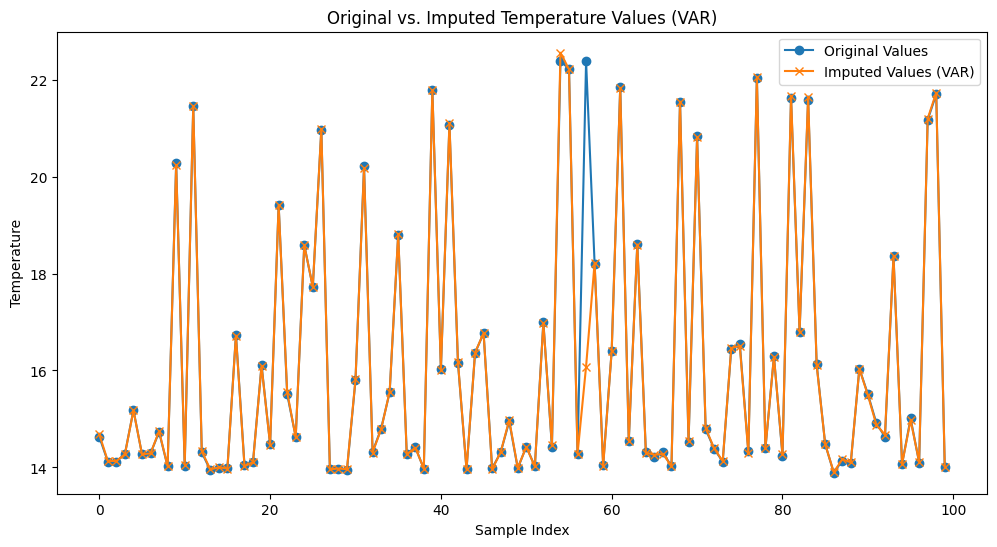

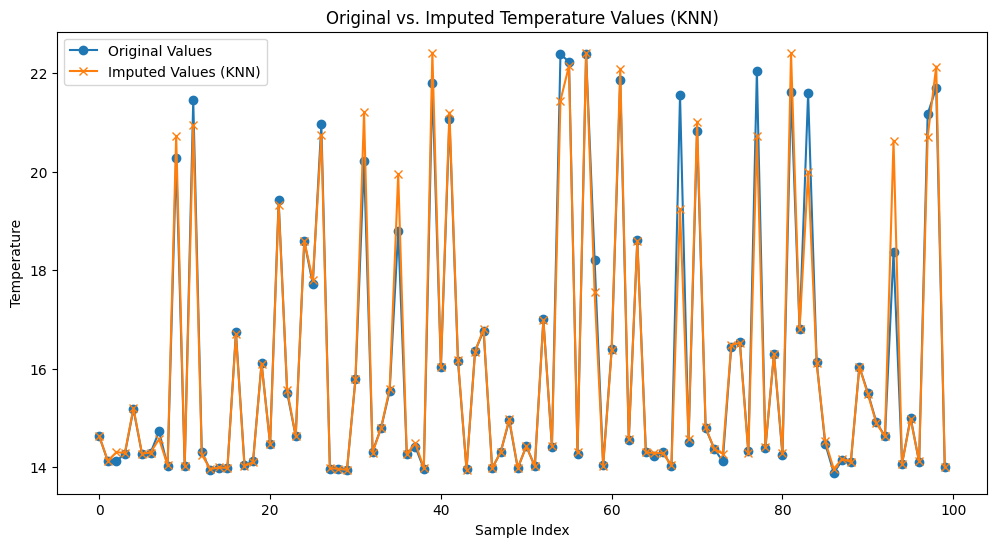

In [ ]:
import seaborn as sns

# Number of points to plot
num_points = 100  # Adjust as needed

# Indices to plot
plot_indices = missing_indices[:num_points]

# Plotting function
def plot_imputed_values(original, imputed, method_name):
    plt.figure(figsize=(12, 6))
    plt.plot(original, label='Original Values', marker='o')
    plt.plot(imputed, label=f'Imputed Values ({method_name})', marker='x')
    plt.title(f'Original vs. Imputed Temperature Values ({method_name})')
    plt.xlabel('Sample Index')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()

# Plot for VAR
plot_imputed_values(
    original_temperature[:num_points],
    imputed_temperature_var[:num_points],
    'VAR'
)

# Plot for KNN
plot_imputed_values(
    original_temperature[:num_points],
    imputed_temperature_knn[:num_points],
    'KNN'
)

# Fed Learning in imputation

In [ ]:
np.random.seed(42)
missing_rate = 0.1
num_missing = int(np.floor(missing_rate * len(sensor3_data_scaled)))
missing_indices = np.random.choice(sensor3_data_scaled.index, num_missing, replace=False)
sensor3_data_missing = sensor3_data_scaled.copy()
sensor3_data_missing.loc[missing_indices, 'Temperature'] = np.nan

# Separate features and target
X = sensor3_data_missing[['Humidity', 'CO2']]
y = sensor3_data_missing['Temperature']

# Original Temperature values
y_original = sensor3_data_scaled.loc[:, 'Temperature']

# Split the data
X_train, X_test, y_train_missing, y_test_missing, y_train_original, y_test_original = train_test_split(
    X, y, y_original, test_size=0.2, random_state=42
)


In [ ]:
# Define Flower client
class ImputationClient(fl.client.NumPyClient):
    def __init__(self, X_train, y_train_missing, y_train_original, X_test, y_test_missing, y_test_original):
        self.X_train = X_train
        self.y_train_missing = y_train_missing
        self.y_train_original = y_train_original
        self.X_test = X_test
        self.y_test_missing = y_test_missing
        self.y_test_original = y_test_original

    def get_parameters(self, config=None):
        return []  # VAR does not have standard parameters like MLP

    def fit(self, parameters, config):
        # Fit a VAR model on non-missing data
        train_data = pd.concat([self.y_train_missing, self.X_train], axis=1).dropna()
        var_model = VAR(train_data)
        self.var_result = var_model.fit(maxlags=1)  # Example: Lag 1
        return [], len(self.X_train), {}

    def evaluate(self, parameters, config):
        # Forecast missing values
        test_data = pd.concat([self.y_test_missing, self.X_test], axis=1).reset_index(drop=True)
        imputed_data = test_data.copy()
        for idx in test_data.index:
            if np.isnan(test_data.loc[idx, 'Temperature']):
                input_data = test_data.loc[max(0, idx - 1):idx - 1, :].dropna()  # Ensure valid indices
                if not input_data.empty:
                    forecast = self.var_result.forecast(input_data.values, steps=1)
                    imputed_data.loc[idx, 'Temperature'] = forecast[0, 0]
                else:
                    # Handle cases where no valid input data exists for forecasting
                    imputed_data.loc[idx, 'Temperature'] = test_data['Temperature'].mean()  # Default to mean as a fallback

        # Evaluate metrics
        mae = np.mean(np.abs(imputed_data['Temperature'] - self.y_test_original.reset_index(drop=True)))
        mse = np.mean((imputed_data['Temperature'] - self.y_test_original.reset_index(drop=True)) ** 2)
        rmse = np.sqrt(mse)
        corr = np.corrcoef(imputed_data['Temperature'], self.y_test_original.reset_index(drop=True))[0, 1]

        return mse, len(self.X_test), {"mae": mae, "rmse": rmse, "corr": corr}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def client_fn(context: Context):
    return NumPyClient.to_client(ImputationClient(X_train, y_train_missing, y_train_original, X_test, y_test_missing, y_test_original))

In [ ]:
# Run the federated learning simulation for 1 rounds (or any desired number of rounds)
start_federated_learning(strategy_name='fedavg', num_rounds=1)

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout
2024-11-27 18:50:16,565	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'memory': 7959365223.0, 'object_store_memory': 3979682611.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 acto

In [ ]:
# Run the federated learning simulation for 1 rounds (or any desired number of rounds)
start_federated_learning(strategy_name='fedprox', num_rounds=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout
2024-11-27 18:50:48,894	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:

In [ ]:
# Run the federated learning simulation for 1 rounds (or any desired number of rounds)
start_federated_learning(strategy_name='fedbuff', num_rounds=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout
2024-11-27 18:51:06,526	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 39

In [ ]:
# Run the federated learning simulation for 1 rounds (or any desired number of rounds)
start_federated_learning(strategy_name='fedasync', num_rounds=1)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout
2024-11-27 18:51:23,847	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node: